# MUSER Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

results_dir = '/tmp/'

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt


from rascil.data_models import PolarisationFrame
from astropy.coordinates import EarthLocation, SkyCoord, ITRS
from rascil.processing_components import create_configuration_from_file
from rascil.processing_components.visibility.coalesce import convert_visibility_to_blockvisibility, \
    convert_blockvisibility_to_visibility
from rascil.processing_components.visibility.base import create_blockvisibility_from_ms, create_visibility_from_ms
from rascil.processing_components import create_visibility, show_image, export_image_to_fits, \
    deconvolve_cube, restore_cube, create_named_configuration, create_test_image, \
    create_image_from_visibility, advise_wide_field, invert_2d, predict_2d
from fund import create_configuration
from muser.data_models.parameters import muser_path, muser_data_path, muser_output_path

import logging
from muser.data_models.parameters import muser_path
import os

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 




In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

Construct LOW core configuration

In [3]:
location = EarthLocation(lon=115.2505 * u.deg, lat=42.211833333 * u.deg, height=1365.0 * u.m)

# conf_dir = muser_path('configurations')

# antfile = os.path.join(conf_dir, 'muser-1.csv')
# lowcore = create_configuration_from_file(antfile=antfile,
#              mount='altaz', names='MUSER_%d',
#              diameter=2.0, name='MUSER', location=location)

# msfile = muser_output_path("CSRH_20151122-125000_100457483.ms")
msfile = muser_output_path("selfmodel.ms")

ch= numpy.arange(1)
vis = create_blockvisibility_from_ms(msfile,  start_chan=52,end_chan=52)

from rascil.processing_components.flagging.operations import flagging_blockvisibility,flagging_blockvisibility_with_bl
bvis = flagging_blockvisibility(vis[0], antenna=[8,9,10,11,27])
baseline = [ [4,0],[4,1],[5,4],[21,4],[24,4],[25,4],[26,4],[27,4],[28,4],[29,4],[30,4],[31,4],[32,4],[36,4],[38,4],[39,4]]
baseline.append([[17,4],[17,13],[19,17],[26,17],[27,17],[28,17],[29,17],[30,17],[31,17],[39,17]])
bvis = flagging_blockvisibility_with_bl(vis[0],baseline)

# Flagging
vt = convert_blockvisibility_to_visibility(bvis)




create_blockvisibility_from_ms: {'type': 'Measurement Set', 'subType': '', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\n'}
create_blockvisibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_blockvisibility_from_ms: Found 2770560 rows
create_blockvisibility_from_ms: Found 64 channels
create_blockvisibility_from_ms: Reading channels from 52 to 52
create_blockvisibility_from_ms: Observation from 2015-11-22 04:50:31.020 to 2015-11-22 04:51:59.995
convert_visibility: Original 3552 rows, 0.551 GB, converted 2770560 rows, 0.413 GB


We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [4]:
advice = advise_wide_field(vt, guard_band_image=3.0, delA=0.1,
                           oversampling_synthesised_beam=4.0)
cellsize = advice['cellsize']

advise_wide_field: (max_wavelength) Maximum wavelength 0.176 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 0.176 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 16606.8 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 16606.8 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 4.5 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0392 (rad) 2.25 (deg) 8.08e+03 (asec)
advise_wide_field: (image_fov) Image field of view 0.118 (rad) 6.74 (deg) 2.42e+04 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 6.02e-05 (rad) 0.00345 (deg) 12.4 (asec)
advise_wide_field: (cellsize) Cellsize 1.51e-05 (rad) 0.000863 (deg) 3.11 (asec)
advice_wide_field: (npixels) Npixels per side = 7810
advice_wide_field: (npixels2) Npixels (power of 2) per side = 8192
advice_wide_field: (npixels23) Npixels (power of 2, 3) per side = 8192
advice_wide_field: (npixels_min) Npixels (power of 2, 3, 4, 5) per side = 8192
advice_wide_field: (w_sampl

Plot the synthesized uv coverage.

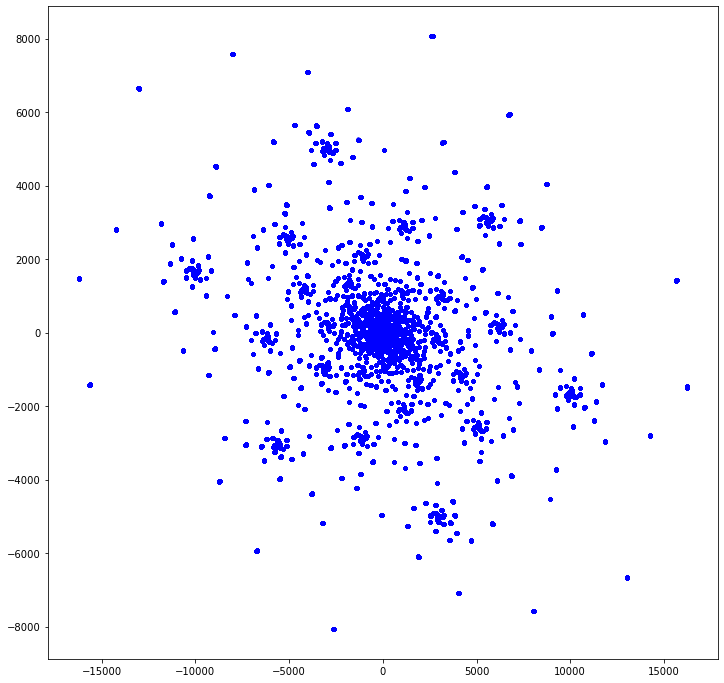

In [5]:
plt.clf()
plt.plot(vt.data['uvw'][:,0], vt.data['uvw'][:,1], '.', color='b')
plt.plot(-vt.data['uvw'][:,0], -vt.data['uvw'][:,1], '.', color='b')
# plt.xlim([-400.0, 400.0])
# plt.ylim([-400.0, 400.0])
plt.show()

Read the venerable test image, constructing an image

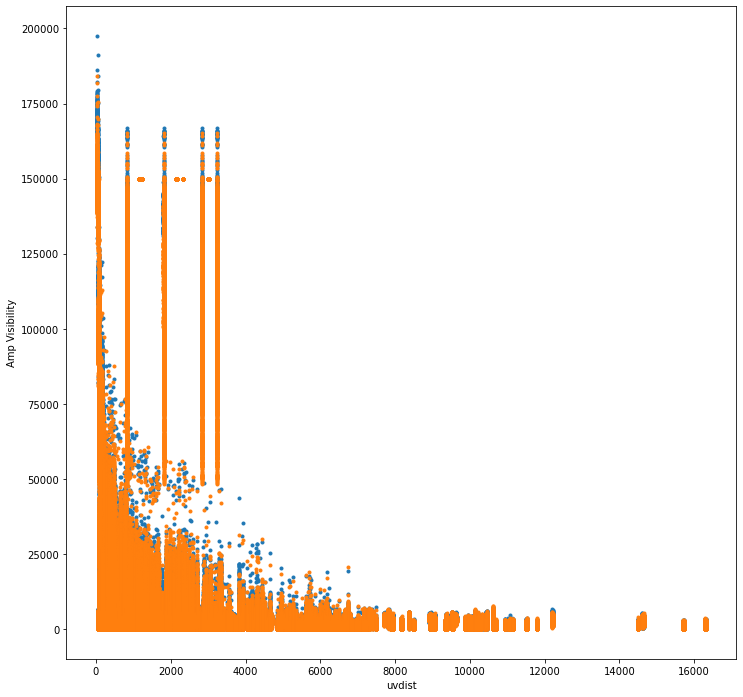

In [6]:
# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Make the dirty image and point spread function

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (237.3576405, -20.05175896)>, starting frequency 1700000000.0 Hz, and bandwidth 24999999.99975 Hz
create_image_from_visibility: uvmax = 16239.832201 wavelengths
create_image_from_visibility: Critical cellsize = 0.000031 radians, 0.001764 degrees
create_image_from_visibility: Cellsize          = 1.50541e-05 radians, 0.000862537 degrees
create_image_from_visibility: image shape is [1, 2, 1024, 1024]


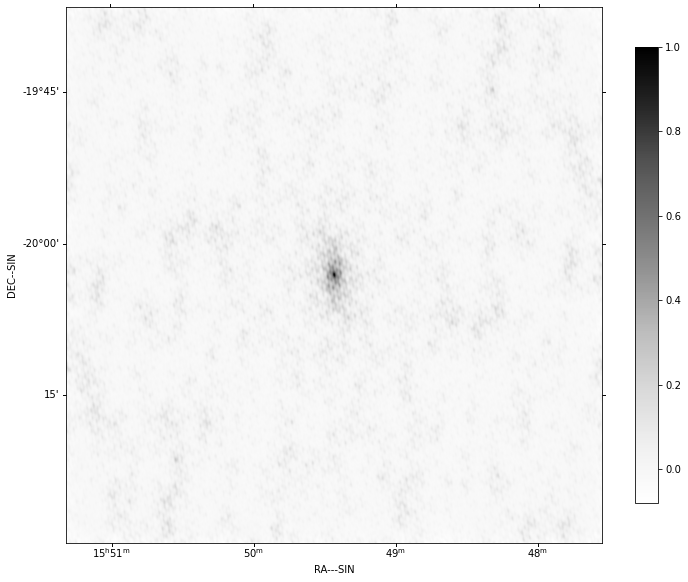

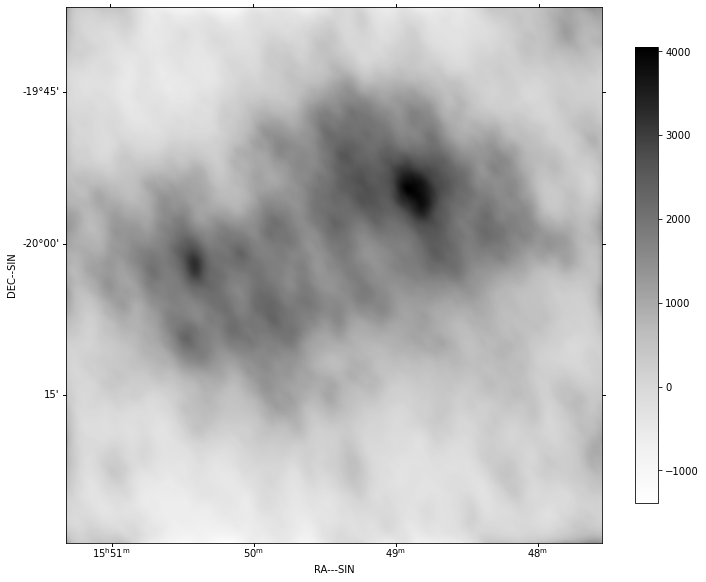

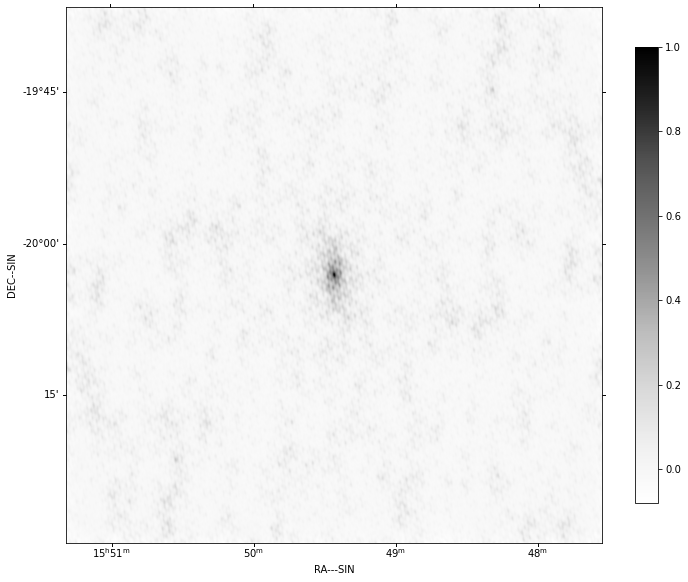

In [7]:
model = create_image_from_visibility(vt, cellsize=cellsize, npixel=1024, polarisation_frame=PolarisationFrame('stokesIV'))
dirty, sumwt = invert_2d(vt, model, context='2d')
psf, sumwt = invert_2d(vt, model, context='2d', dopsf=True)

show_image(dirty)
show_image(psf)
# print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

# print("Max, min in PSF         = %.6f, %.6f, sumwt = %f" % (psf.data.max(), psf.data.min(), sumwt))

# export_image_to_fits(dirty, '%s/imaging_dirty.fits'%(results_dir))
# export_image_to_fits(psf, '%s/imaging_psf.fits'%(results_dir))

Deconvolve using clean

deconvolve_cube : Cleaning entire image
deconvolve_cube : PSF support = +/- 512 pixels
deconvolve_cube : PSF shape (1, 2, 1024, 1024)
deconvolve_cube : Multi-scale clean of each polarisation and channel separately
deconvolve_cube : Processing pol 0, channel 0
msclean : Peak of PSF = 1.0000000000000004 at (512, 512)
msclean : Peak of Dirty = 4057.159743 Jy/beam at (676, 654) 
msclean : Coupling matrix =
 [[1.         0.9905119  0.87783116 0.60427548 0.487158   0.32804854]
 [0.9905119  0.98139581 0.87253458 0.60355445 0.48690022 0.32798792]
 [0.87783116 0.87253458 0.80468507 0.59307275 0.48304853 0.32707363]
 [0.60427548 0.60355445 0.59307275 0.52791418 0.45387394 0.31953618]
 [0.487158   0.48690022 0.48304853 0.45387394 0.40989687 0.30573973]
 [0.32804854 0.32798792 0.32707363 0.31953618 0.30573973 0.25741135]]
msclean : Max abs in dirty Image = 4057.159743 Jy/beam
msclean : Start of minor cycle
msclean : This minor cycle will stop at 100 iterations or peak < 4.057160 (Jy/beam)
msclean 

Text(0.5, 1.0, 'Restored')

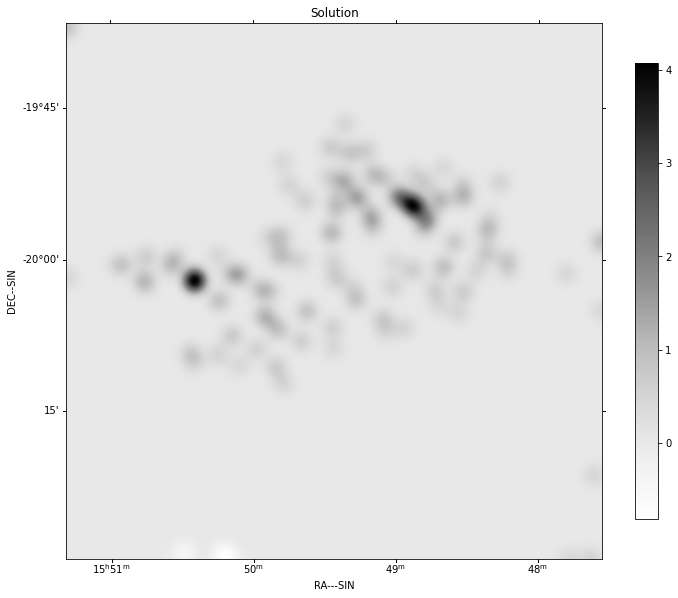

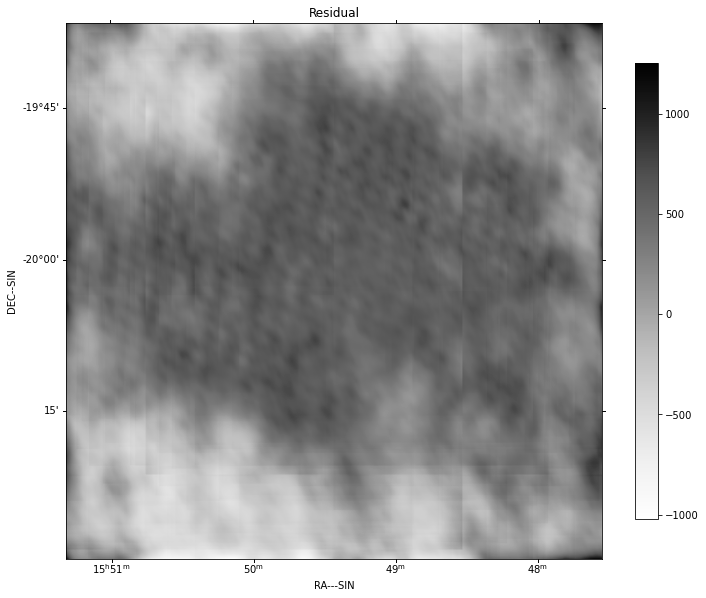

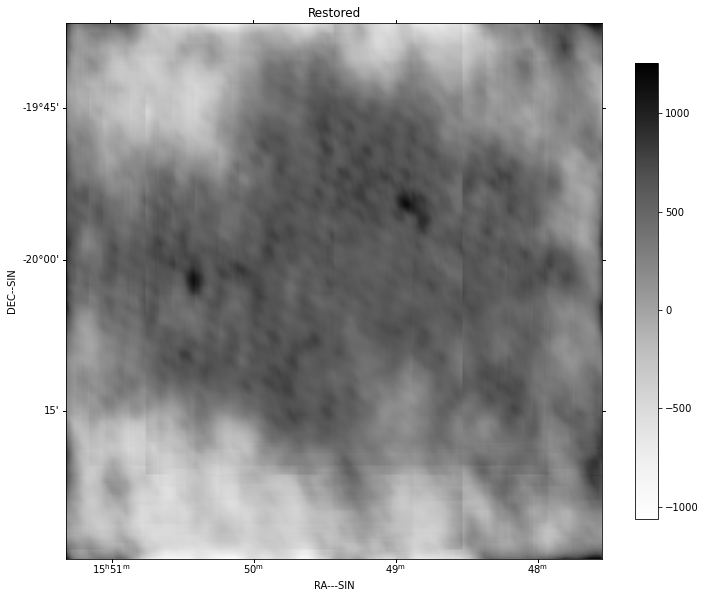

In [8]:
comp, residual = deconvolve_cube(dirty, psf, niter=100, threshold=0.001, fractional_threshold=0.001,
                                 gain=0.2,algorithm='msclean',scales=[0, 3, 10 ,30, 50,100])

restored = restore_cube(comp, psf, residual)

# Show the results

fig=show_image(comp)
plt.title('Solution')
fig=show_image(residual)
plt.title('Residual')
fig=show_image(restored)
plt.title('Restored')

Predict the visibility of the model

Now we will plot the original visibility and the residual visibility.